In [3]:
import geopandas as gpd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import gzip
import shutil
import glob

In [4]:
%env OPENBLAS_NUM_THREADS=4

env: OPENBLAS_NUM_THREADS=4


In [5]:
# Set data directory
data_dir = '../../datasets/'

monthly_sh = os.path.join(data_dir, 'ITSG_grace2018/monthly/monthly_n96/')
static =  os.path.join(data_dir, 'ITSG_grace2018/monthly/static/')
background =  os.path.join(data_dir, 'ITSG_grace2018/monthly/monthly_background/')

In [6]:
os.listdir(monthly_sh)

['ITSG-Grace2018_n96_2013-12.gfc',
 'ITSG-Grace2018_n96_2009-07.gfc',
 'ITSG-Grace2018_n96_2003-05.gfc',
 'ITSG-Grace2018_n96_2004-09.gfc',
 'ITSG-Grace2018_n96_2003-02.gfc',
 'ITSG-Grace2018_n96_2012-07.gfc',
 'ITSG-Grace2018_n96_2002-10.gfc',
 'ITSG-Grace2018_n96_2008-12.gfc',
 'ITSG-Grace2018_n96_2004-07.gfc',
 'ITSG-Grace2018_n96_2012-09.gfc',
 'ITSG-Grace2018_n96_2015-02.gfc',
 'ITSG-Grace2018_n96_2014-10.gfc',
 'ITSG-Grace2018_n96_2005-12.gfc',
 'ITSG-Grace2018_n96_2009-09.gfc',
 'ITSG-Grace2018_n96_2007-04.gfc',
 'ITSG-Grace2018_n96_2016-01.gfc',
 'ITSG-Grace2018_n96_2006-11.gfc',
 'ITSG-Grace2018_n96_2007-03.gfc',
 'ITSG-Grace2018_n96_2016-06.gfc',
 'ITSG-Grace2018_n96_2010-11.gfc',
 'ITSG-Grace2018_n96_2011-03.gfc',
 'ITSG-Grace2018_n96_2016-08.gfc',
 'ITSG-Grace2018_n96_2011-04.gfc',
 'ITSG-Grace2018_n96_2010-07.gfc',
 'ITSG-Grace2018_n96_2006-09.gfc',
 'ITSG-Grace2018_n96_2011-12.gfc',
 'ITSG-Grace2018_n96_2017-05.gfc',
 'ITSG-Grace2018_n96_2007-12.gfc',
 'ITSG-Grace2018_n96

In [7]:
aoi = os.path.join(data_dir, 'gha/gha.shp')
gha = gpd.read_file(aoi)

gha.head(5)

,OBJECTID,COUNTRY,area,Shape_Leng,Shape_Area,land_under,geometry
0,1,Burundi,0.0,8.560371,2.193095,None,"POLYGON ((30.36003 -2.35343, 30.36209 -2.35250..."
1,2,Djibouti,0.0,7.874779,1.781569,None,"POLYGON ((42.66339 11.07150, 42.65628 11.07671..."
2,3,Eritrea,0.0,41.125347,10.077064,None,"MULTIPOLYGON (((43.14681 12.71384, 43.14167 12..."
3,4,Ethiopia,0.0,49.028874,92.986294,None,"POLYGON ((41.77824 11.54207, 41.77785 11.51077..."
4,5,Kenya,0.0,40.625985,47.319578,None,"MULTIPOLYGON (((39.40283 -4.65471, 39.40523 -4..."


### Read monthly solutions Stokes coefficients form directory path

In [8]:
def load_icgem_files(datadir):

    gsm = []
    deg1_terms = []
    term_c20 = []
    files = os.listdir(datadir)

    for file in files:
        file_path = os.path.join(datadir, file)
        if "ITSG-Grace2018" in file:
            gsm.append(xr.open_dataset(file_path, engine="icgem"))
        if "c20" in file:
            term_c20.append(xr.open_dataset(file_path, engine="icgem"))
        elif "degree1" in file:
            deg1_terms.append(xr.open_dataset(file_path, engine="icgem"))  ## Depending on the gravitational spherical harmonic model, the engine can be = "gsmv6"

    if deg1_terms and term_c20:
        deg1_cnm = xr.concat(deg1_terms, dim="time").sortby("time")
        c20_cnm = xr.concat(term_c20, dim="time").sortby("time")
        return deg1_cnm, c20_cnm
    else:
        dsgsm = xr.concat(gsm, dim="time")
        dsgsm = dsgsm.sortby('time')
        return dsgsm

In [9]:
# Load monthly data

monthly_data = os.path.expanduser(monthly_sh)

monthly_sh_data = load_icgem_files(monthly_data)
monthly_sh_data

<xarray.Dataset>
Dimensions:  (time: 162, nm: 9409)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1 2 2 2 2 2 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 0 1 -1 0 1 -1 2 -2 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    cnm      (time, nm) float64 1.0 0.0 0.0 ... 2.452e-10 -2.245e-09 1.527e-09
    sigcnm   (time, nm) float64 0.0 0.0 0.0 ... 5.098e-11 2.906e-11 2.797e-11
Attributes:
    nmaxfile:   96
    nmax:       96
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018_n96_2013-12

### Degree corrections

#### C20 coefficient correction 

In [10]:
# Read the degree  coefficients
background_data = os.path.expanduser(background)

ds_deg1, ds_c20 = load_icgem_files(background_data)

In [11]:
ds_deg1

<xarray.Dataset>
Dimensions:  (time: 162, nm: 4)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1
  * m        (nm) int64 0 0 1 -1
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    cnm      (time, nm) float64 0.0 6.217e-10 ... -6.684e-11 -8.638e-11
Attributes:
    nmaxfile:   1
    nmax:       1
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  model_degree1_2002-11

In [12]:
# Select degree 20 order 0
c20 = ds_c20.cnm.sel(n=2, m =0)

monthly_sh_data.cnm.loc[{'n': 2, 'm': 0}]= c20.values

In [13]:
monthly_sh_data

<xarray.Dataset>
Dimensions:  (time: 162, nm: 9409)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1 2 2 2 2 2 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 0 1 -1 0 1 -1 2 -2 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    cnm      (time, nm) float64 1.0 0.0 0.0 ... 2.452e-10 -2.245e-09 1.527e-09
    sigcnm   (time, nm) float64 0.0 0.0 0.0 ... 5.098e-11 2.906e-11 2.797e-11
Attributes:
    nmaxfile:   96
    nmax:       96
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018_n96_2013-12

In [14]:
# Select degree 1 terms
deg1_terms = ds_deg1.cnm.sel(n=1)

In [15]:
# Update the terms
for m in [0, 1, -1]:
    monthly_sh_data.cnm.loc[{'n': 1, 'm': m}] = deg1_terms.sel(m=m)

In [16]:
monthly_sh_data

<xarray.Dataset>
Dimensions:  (time: 162, nm: 9409)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1 2 2 2 2 2 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 0 1 -1 0 1 -1 2 -2 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    cnm      (time, nm) float64 1.0 6.217e-10 1.842e-10 ... -2.245e-09 1.527e-09
    sigcnm   (time, nm) float64 0.0 0.0 0.0 ... 5.098e-11 2.906e-11 2.797e-11
Attributes:
    nmaxfile:   96
    nmax:       96
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018_n96_2013-12

#### Read the time-invariable static gravity field data

In [17]:

static_data = os.path.expanduser(static)
name= "ITSG-Grace2018s.gfc"
file_path = os.path.join(static_data, name)
dsstatic = xr.open_dataset(file_path, engine="icgem")
dsstatic

<xarray.Dataset>
Dimensions:  (nm: 40401)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1 2 2 2 2 2 ... 200 200 200 200 200 200 200 200
  * m        (nm) int64 0 0 1 -1 0 1 -1 2 ... -197 198 -198 199 -199 200 -200
Data variables:
    cnm      (nm) float64 ...
    sigcnm   (nm) float64 ...
Attributes:
    nmaxfile:   200
    nmax:       200
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018s

In [18]:
# Substract static field from sh data
monthly_sh_data["dcnm"]=monthly_sh_data.cnm-dsstatic.cnm

In [19]:
# 
ds1 = monthly_sh_data.sh.truncate(monthly_sh_data.sh.nmax, 1)

In [20]:
ds1

<xarray.Dataset>
Dimensions:  (time: 162, nm: 9408)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 1 1 1 2 2 2 2 2 3 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 1 -1 0 1 -1 2 -2 0 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    cnm      (time, nm) float64 6.217e-10 1.842e-10 ... -2.245e-09 1.527e-09
    sigcnm   (time, nm) float64 0.0 0.0 0.0 ... 5.098e-11 2.906e-11 2.797e-11
    dcnm     (time, nm) float64 6.217e-10 1.842e-10 ... -1.152e-11 -5.138e-12
Attributes:
    nmaxfile:   96
    nmax:       96
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018_n96_2013-12

#### Calculate terrestrial water storage change in spectral domain

In [21]:
datws=ds1.dcnm.sh.tws()
display(datws)

shxarray-INFO: /home/jovyan/.cache/shxarray_storage/Love/geoslurp_dump_llove.sql already exists, no need to download)


<xarray.DataArray 'tws' (time: 162, nm: 9408)>
array([[ 2.13225571e-02,  6.31603642e-03, -1.46070734e-02, ...,
        -3.80599647e-01, -1.10550524e-01,  1.34023377e-01],
       [-1.25740602e-03,  1.13329913e-02, -1.66096628e-02, ...,
         8.03981056e-02, -2.37433310e-03, -4.91293443e-01],
       [-1.89545740e-03,  1.47784819e-03,  1.02669347e-02, ...,
         7.28700069e-02, -4.68987949e-02, -7.08848019e-02],
       ...,
       [ 1.22721888e-02,  9.67697444e-03, -4.97693244e-03, ...,
         1.73845228e-01, -1.29881353e-02, -3.46689078e-02],
       [ 1.91249167e-04,  1.15255401e-02, -9.62223560e-03, ...,
        -2.75112923e-02,  3.00423718e-02,  6.89224888e-02],
       [-9.21925667e-03, -2.29233654e-03, -2.96261263e-03, ...,
        -6.81238770e-02, -2.64771303e-02, -1.18127543e-02]])
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 1 1 1 2 2 2 2 2 3 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 1 -1 0 1 -1 2 -2 0 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Attributes:
    units:      m
    long_name:  Total water storage
    gravtype:   tws

#### Calculate terrestrial water storage change in spatial domain globally

In [22]:
dsgrd=datws.sh.synthesis()

In [26]:
dsgrd = dsgrd.to_dataset(name='tws')

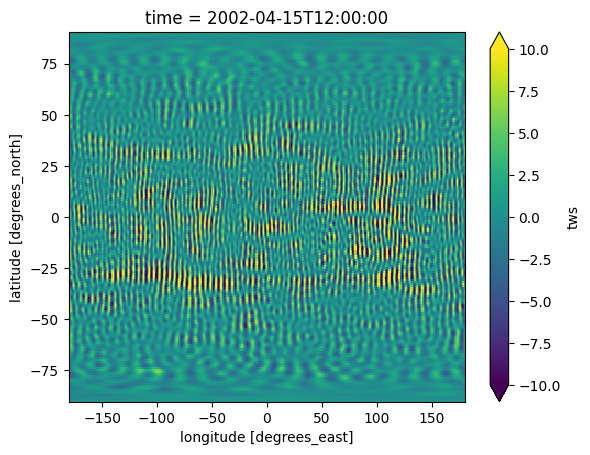

In [27]:
islice=0
dsgrd.tws[:,:,islice].plot(vmin=-10, vmax =10)
dsgrd
lats = dsgrd['lat'].values
lons = dsgrd['lon'].values

#### Apply filters

In [28]:
# Guassian isotropic filter
dsgrd["twsgauss"]=datws.sh.filter('Gauss350').sh.synthesis()
# Anisotropic decorrelation filter
dsgrd["twsddk"]=datws.sh.filter('DDK5').sh.synthesis()


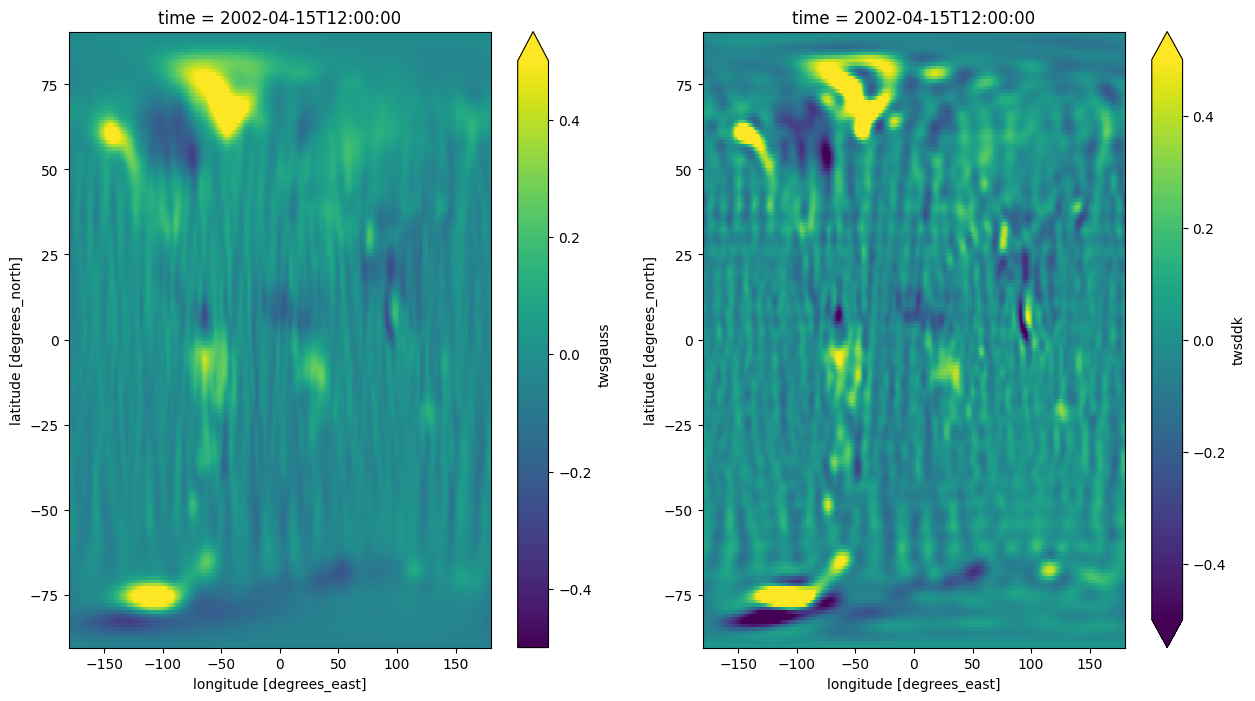

In [29]:
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))
vmin=-0.5
vmax=0.5

islice=0
dsgrd.twsgauss[:,:,islice].plot(ax=axs[0],vmin=vmin,vmax=vmax)
dsgrd.twsddk[:,:,islice].plot(ax=axs[1],vmin=vmin,vmax=vmax)

In [30]:
dsgrd

<xarray.Dataset>
Dimensions:   (time: 162, lat: 181, lon: 361)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
  * lat       (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    tws       (lat, lon, time) float64 0.3597 -0.189 ... -0.07894 -0.06017
    twsgauss  (lat, lon, time) float64 -0.06363 -0.02915 ... 0.01947 -0.05727
    twsddk    (lat, lon, time) float64 0.0238 -0.03872 ... 0.01806 -0.03132

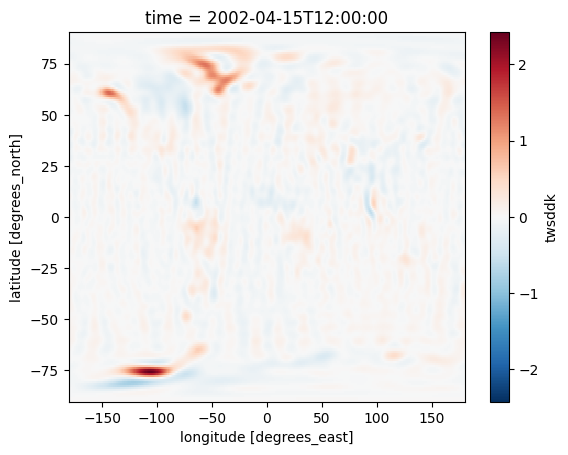

In [34]:
dsgrd.twsddk.isel(time=0).plot()

In [ ]:
# Save the output TWS
dsgrd.to_netcdf("TWS.nc")

## TWS pre-processing

### Calculate baseline average

In [ ]:
''''
Study period: 2004 - 2024
'''
# Path to your .tif files
tif_files = sorted(glob.glob("path_to_tif_files/*.tif"))

# Extract dates from filenames (assuming filenames are formatted like chirps-v2.0.1981.07.tif)
dates = [pd.to_datetime(f.split('/')[-1].split('.')[2] + f.split('/')[-1].split('.')[3].replace('.tif', ''), format='%Y.%m') for f in tif_files]

# Load all TIFFs into an xarray DataArray
data_array = xr.concat(
    [xr.open_rasterio(tif).sel(band=1) for tif in tif_files],
    dim=pd.Index(dates, name="time")
)

# Set meaningful coordinates
data_array.name = "precipitation"  # Name the data
data_array.attrs["units"] = "mm"
print(data_array)
